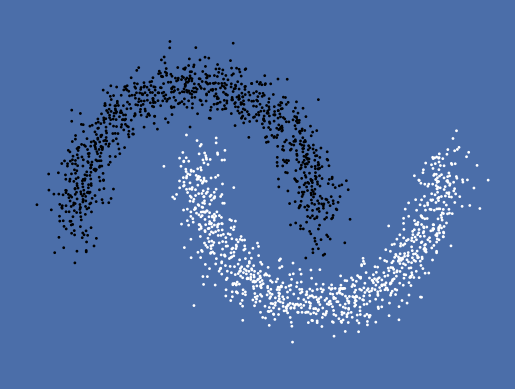

In [1]:
# all of these libraries are used for plotting
import numpy as np
import matplotlib.pyplot as plt

# Plot the dataset
def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

from sklearn.datasets import make_moons
X, Y = make_moons(n_samples=2000, noise=0.1)

%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()

In [2]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))

# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting
    Z = classifier.forward(to_forward)
    Z = Z.reshape(xx.shape)
    
    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    
    # then plot the dataset
    plot_data(ax, X,Y)

In [3]:
class MyReLU(object):
    def forward(self, x):
        self.x = x
        return x * (x > 0)
        
    def backward(self, grad_output):
        return grad_output * (self.x > 0)
        
    def step(self, learning_rate):
        pass  # no parameters to update

class MySigmoid(object):
    def forward(self, x):
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, grad_output):
        return grad_output * self.output * (1 - self.output)

    def step(self, learning_rate):
        pass  # no parameters to update

In [76]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        self.n_output = n_output
        self.n_input = n_input
        self.mu_w = np.random.randn(n_output, n_input).reshape(-1, 1)
        self.mu_b = np.random.randn(n_output, 1)
        self.sigma_w = (np.random.randn(n_output, n_input).reshape(-1, 1))**2
        self.sigma_b = np.random.randn(n_output, 1)**2

    def forward(self, x):
        self.x = x
        #self.weights = np.random.normal(self.mu_w, np.sqrt(self.sigma_w)).reshape(self.n_output, self.n_input)
        self.weights = np.random.multivariate_normal(mean = self.mu_w.reshape(-1), cov = np.diag(self.sigma_w.flatten()))
        self.weights = self.weights.reshape(self.n_output, self.n_input)

        #self.bias = np.random.normal(self.mu_b, np.sqrt(self.sigma_b))
        self.bias = np.random.multivariate_normal(self.mu_b.reshape(-1), np.diag(self.sigma_b.flatten()))


        return np.dot(x, self.weights.T) + self.bias

    def backward(self, grad_output):
        self.grad_weights = np.outer(grad_output, self.x)

        self.grad_bias = np.sum(grad_output, axis = 0)
        return self.weights.T@grad_output
    
    def step(self, learning_rate = 0.01):
        

        self.sigma_w = ((1 - learning_rate) * self.sigma_w + (self.grad_weights**2).reshape(-1, 1) * learning_rate)
        self.sigma_b = (1 - learning_rate) * self.sigma_b + self.grad_bias**2 * learning_rate

        self.mu_w -= (self.grad_weights.reshape(-1, 1) / self.sigma_w) * learning_rate
        self.mu_b -= (self.grad_bias / self.sigma_b) * learning_rate

In [77]:
class MLP(object):
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def compute_loss3(self, out, label):    
        if out==0:
            out=1e-10
        loss=-np.mean((label * np.log(out) + (1-label) * np.log(1-out)))
        self.grad_output=-((label/out)+(label-1)/(1-out))
        return loss
    
    def compute_loss(self, out, label):
        BCE = -label*np.log(out[0])+(1-label)*np.log(1-out[0])
        self.grad_output = -(label/(out[0]+10**(-10)) - (1 - label) / (1 - out[0]+10**(-10)))
        return BCE
    
    def compute_loss2(self, out, label):
        # case where label is 0
        if label == 0:
            grad_output = -1 / (1 - out + 1e-10)
            loss0 = -np.mean(np.log(1 - out + 1e-10))
            self.grad_output = grad_output
            return loss0
        
        # case where label is 1
        grad_output = 1 / (out + 1e-10)
        loss1 = -np.mean(np.log(out + 1e-10))
        self.grad_output = grad_output
        return loss1

    def backward(self):
        grad_output = self.grad_output
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
        # return grad_output

    def step(self, learning_rate):
        for layer in self.layers:
            layer.step(learning_rate)

    def train(self, X, y, n_iter, learning_rate):
        for _ in range(n_iter):
            loss = 0
            for x, label in zip(X, y):
                out = self.forward(x)
                loss += self.compute_loss(out, label)
                self.backward()
            loss /= len(X)
            self.step(learning_rate)
            print(loss)

In [78]:
h=50

# define your network with your Sequential
# it should be a linear layer with 2 inputs and h outputs, followed by a ReLU
# then a linear layer with h inputs and 1 outputs, followed by a sigmoid
# feel free to try other architectures

net = MLP([MyLinear(2, h), MyReLU(), MyLinear(h, 1), MySigmoid()])

[[-0.7475567 ]
 [-1.02413327]
 [ 0.7282308 ]
 [-0.05765917]
 [ 1.7405357 ]
 [ 1.09482312]
 [ 0.72577245]
 [ 0.10445258]
 [ 0.50604493]
 [-0.03734234]
 [-0.47112977]
 [-0.07802649]
 [-0.05165607]
 [ 0.22450771]
 [ 3.36264588]
 [-1.05566998]
 [-1.00477757]
 [-1.45999935]
 [-0.08407553]
 [ 0.14624778]
 [ 0.01034515]
 [ 0.53700834]
 [-0.45775981]
 [ 1.04294454]
 [ 0.52752012]
 [ 0.64021298]
 [-0.45662119]
 [ 0.52365853]
 [ 0.23769224]
 [-0.35295848]
 [ 1.14158656]
 [-0.00504004]
 [-0.20558223]
 [-0.11535558]
 [-1.81531662]
 [ 0.41991748]
 [ 0.88028478]
 [ 0.72653184]
 [ 0.00899889]
 [ 0.94252045]
 [-0.48588865]
 [-2.72487035]
 [-0.9023386 ]
 [-0.81091393]
 [-0.65117519]
 [-0.3269291 ]
 [ 1.0101707 ]
 [ 0.71506225]
 [-0.73600343]
 [ 0.91796518]
 [ 1.22318919]
 [ 1.33054295]
 [-0.58172753]
 [ 1.35621135]
 [ 0.12216233]
 [ 0.65117872]
 [ 1.33316322]
 [-1.02890697]
 [ 0.33728916]
 [ 0.2712826 ]
 [-0.62392655]
 [-1.51043582]
 [ 0.95483402]
 [ 0.82759583]
 [ 0.89868177]
 [ 0.47821834]
 [-0.61428

/var/folders/kk/m7r241y560174wvw5cvj2dfm0000gn/T/ipykernel_57556/118718062.py:18: RuntimeWarning: divide by zero encountered in log
  BCE = -label*np.log(out[0])+(1-label)*np.log(1-out[0])
/var/folders/kk/m7r241y560174wvw5cvj2dfm0000gn/T/ipykernel_57556/118718062.py:18: RuntimeWarning: invalid value encountered in scalar multiply
  BCE = -label*np.log(out[0])+(1-label)*np.log(1-out[0])


[[-1.34780661e+00]
 [-9.98027029e-01]
 [ 1.73887001e+00]
 [-1.73563861e-01]
 [ 1.71181423e+00]
 [ 1.04889051e+00]
 [ 5.57629490e-01]
 [-8.99637214e-02]
 [ 6.19394677e-01]
 [-1.96079532e+00]
 [-3.53051251e-01]
 [-1.43428845e+00]
 [-1.61003080e-01]
 [-4.52503308e-03]
 [ 3.29232435e+00]
 [ 2.29752678e-01]
 [-4.18229653e-01]
 [-2.55009117e+00]
 [-2.37903900e-01]
 [ 3.80296465e-01]
 [-3.70044735e-03]
 [ 1.10552755e+00]
 [-5.35061668e-01]
 [ 1.00095658e+00]
 [ 4.67653062e-01]
 [ 3.38693068e+00]
 [-7.78003232e-01]
 [ 8.10693594e-01]
 [ 1.95383204e-01]
 [-2.22831021e-01]
 [ 1.19522647e+00]
 [-1.70332855e-02]
 [-8.85100934e-02]
 [-8.36199823e-01]
 [-2.18842205e+00]
 [ 7.55929742e-01]
 [ 4.15612591e-01]
 [ 1.07596047e+00]
 [-4.90099779e-01]
 [ 1.27306355e+00]
 [-1.30337149e-01]
 [-2.95240400e+00]
 [-1.60768842e-01]
 [-2.91269551e+00]
 [ 1.36708335e+00]
 [-3.24598077e+00]
 [ 1.26633807e+00]
 [ 4.31299872e-01]
 [-1.01842590e+00]
 [ 4.54975453e-01]
 [ 1.26572841e+00]
 [ 4.29707064e-01]
 [-9.9986583

KeyboardInterrupt: 

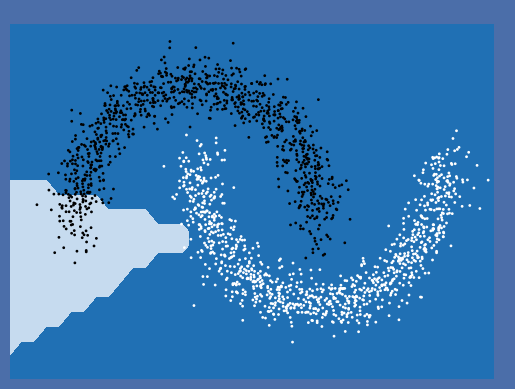

In [79]:
# unfortunately animation is not working on colab
# you should comment the following line if on colab
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
losses = []
learning_rate = 1e-2
for it in range(10000):
    
    # pick a random example id
    j = np.random.randint(1, len(X))


    # select the corresponding example and label
    example = X[j:j+1][0]
    
    label = Y[j]
    

    # do a forward pass on the example
    out = net.forward(example)

    # compute the loss according to your output and the label
    # YOUR CODE HERE
    loss = net.compute_loss(out, label)
    
    losses.append(loss)
    
    
    # backward pass
    # YOUR CODE HERE
    net.backward()
    
    # gradient step
    # YOUR CODE HERE
    net.step(learning_rate)

    # draw the current decision boundary every 250 examples seen
    if it % 250 == 0 : 
        fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        plot_decision_boundary(ax, x_min, x_max, y_min, y_max, X, Y, net)
        plt.show()
        """
        for layer in net.layers:
            if hasattr(layer, 'mu_w'):
                print(layer.mu_w)
                print(layer.mu_b)
                print(layer.sigma_w)
                print(layer.sigma_b)
        """

In [51]:
sigma_w = (np.random.randn(10, 10).reshape(-1, 1))**2
print(sigma_w.shape)
print(np.diag(sigma_w.flatten()).shape)

(100, 1)
(100, 100)
